In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import os 
import matplotlib.pyplot as plt
import numpy as np

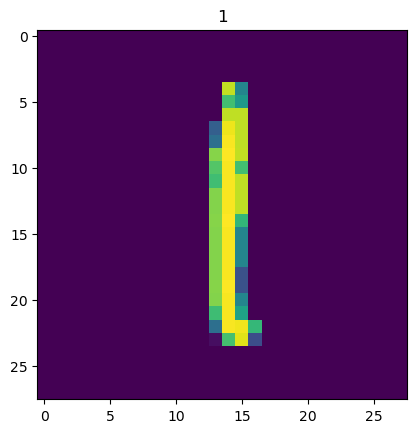

In [17]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
r = np.random.randint(0, x_train.shape[0])
image = x_train[r]
label = y_train[r]
# print (image_1)
plt.imshow(image)
plt.title(label)
plt.show()



In [18]:
(x_train, x_test) = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0, x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [19]:
# CNN -> BatchNorm -> ReLU (common structure)
class CNNBlock(layers.Layer):
    def __init__(self, out_channels, kernel_size=3):
        super(CNNBlock, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, padding="same")
        self.bn = layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x
    
model = keras.Sequential(
    [
        CNNBlock(32),
        CNNBlock(64),
        CNNBlock(128),
        layers.Flatten(),
        layers.Dense(10),
    ]
)

class Resblock(layers.Layer):
    def __init__(self, channels):
        super(Resblock, self).__init__()
        self.channels = channels
        self.cnn1 = CNNBlock(channels[0], 3)
        self.cnn2 = CNNBlock(channels[1], 3)
        self.cnn3 = CNNBlock(channels[2], 3)
        self.pooling = layers.MaxPooling2D()
        self.identity_mapping = layers.Conv2D(channels[1], 3, padding="same")

    def call(self, input_tensor, training=False):
        x = self.cnn1(input_tensor, training=training)
        x = self.cnn2(x, training=training)
        x = self.cnn3(x + self.identity_mapping(input_tensor), training=training,)
        return self.pooling(x)
    
class ResNet_Like(keras.Model):
    def __init__(self, num_classes=10):
        super(ResNet_Like, self).__init__()
        self.block1 = Resblock([32, 32, 64])
        self.block2 = Resblock([128, 128, 256])
        self.block3 = Resblock([128, 256, 512])
        self.pool = layers.GlobalAveragePooling2D()
        self.classifier = layers.Dense(num_classes)

    def call(self, input_tensor, training=False):
        x = self.block1(input_tensor, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.pool(x)
        return self.classifier(x) 
    
model = ResNet_Like(num_classes=10)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=3, verbose=2)
model.evaluate(x_test, y_test, batch_size=64, verbose=2)
model.summary()

Epoch 1/3
938/938 - 253s - 270ms/step - accuracy: 0.9718 - loss: 0.0939
Epoch 2/3
938/938 - 248s - 264ms/step - accuracy: 0.9888 - loss: 0.0363
Epoch 3/3
938/938 - 252s - 268ms/step - accuracy: 0.9906 - loss: 0.0295
157/157 - 11s - 68ms/step - accuracy: 0.9798 - loss: 0.0674


Model: "res_net__like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resblock (Resblock)             │ ?                      │        28,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resblock_1 (Resblock)           │ ?                      │       592,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resblock_2 (Resblock)           │ ?                      │     2,364,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,965,568 (34.20 MB)

 Trainable params: 2,987,498 (11.40 MB)

 Non-trainable params: 3,072 (12.00 KB)

 Optimizer params: 5,974,998 (22.79 MB)

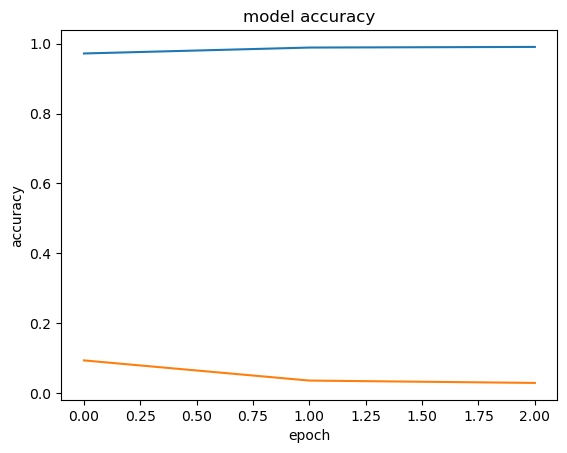

In [20]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step


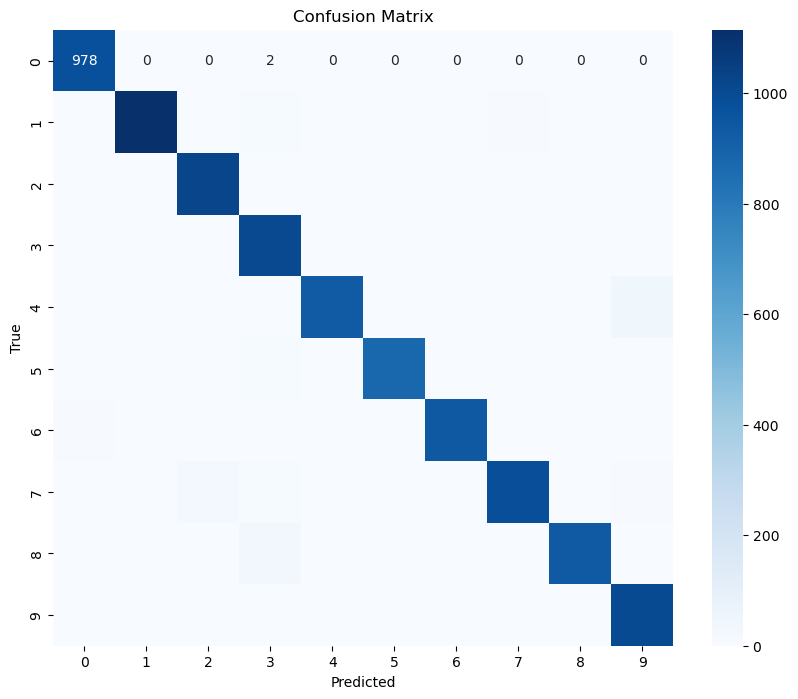

Accuracy: 97.98%


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test set
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)  # Convertir les prédictions en labels

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # cm is the confusion matrix, annot=True adds the numbers to the plot, fmt='d' formats the numbers as integers
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Pourcentage de bonnes prédictions
accuracy = sum(y_test == y_pred) / len(y_test)
print(f"Accuracy: {accuracy * 100}%")

[7 2 1 ... 4 5 6]


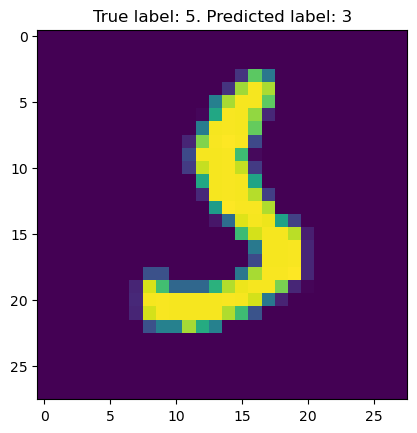

In [22]:
x_test.shape
print(y_pred)

# afficher les images mal prédites
misclassified_idx = np.where(y_pred != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28))
plt.title(f"True label: {y_test[i]}. Predicted label: {y_pred[i]}")
plt.show()

In [23]:
# Save the model
model.save("model_CNN_MNIST.keras")

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

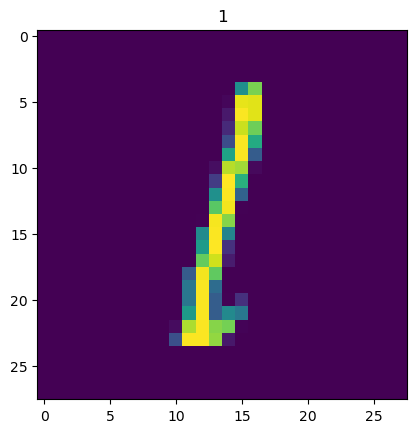

In [25]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
r = np.random.randint(0, len(x_train))
image = x_train[r]
label = y_train[r]
plt.imshow(image)
plt.title(label)
plt.show

In [26]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255 
print(x_train.shape)

(60000, 28, 28, 1)


In [27]:
class Dense(layers.Layer):
    def __init__(self, units) :
        super(Dense, self).__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'w',
            shape = (input_shape[-1], self.units),
            initializer = 'random_normal',
            trainable = True,
        )
    
        self.b = self.add_weight(
            name = 'b',
            shape = (self.units, ),
            initializer = 'zeros',
            trainable = True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b   

class my_model(keras.Model):
    def __init__(self,num_classes = 10):
        super(my_model, self).__init__()
        self.dense1 = Dense(64)
        self.dense2 = Dense(num_classes)
        self.flatten = layers.Flatten()
    def call(self, input_tensor):
        x = tf.nn.relu(self.dense1(input_tensor))
        x = self.flatten(x)
        return self.dense2(x)

In [28]:
# Initialize the model
model = my_model()

# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=2)

# Evaluate the model
model.evaluate(x_test, y_test)

# Print the model summary
model.summary()

Epoch 1/10
1875/1875 - 6s - 3ms/step - accuracy: 0.8973 - loss: 0.3614
Epoch 2/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9184 - loss: 0.2912
Epoch 3/10
1875/1875 - 6s - 3ms/step - accuracy: 0.9212 - loss: 0.2796
Epoch 4/10
1875/1875 - 6s - 3ms/step - accuracy: 0.9231 - loss: 0.2724
Epoch 5/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9242 - loss: 0.2682
Epoch 6/10
1875/1875 - 6s - 3ms/step - accuracy: 0.9269 - loss: 0.2646
Epoch 7/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9277 - loss: 0.2615
Epoch 8/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9290 - loss: 0.2561
Epoch 9/10
1875/1875 - 6s - 3ms/step - accuracy: 0.9298 - loss: 0.2512
Epoch 10/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9315 - loss: 0.2459
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.9178 - loss: 0.2964


Model: "my_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ ?                      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │       501,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 50176)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,505,696 (5.74 MB)

 Trainable params: 501,898 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,003,798 (3.83 MB)

In [1]:
# afficher les images mal prédites
misclassified_idx = np.where(y_pred != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28))
plt.title(f"True label: {y_test[i]}. Predicted label: {y_pred[i]}")
plt.show()

NameError: name 'np' is not defined

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Dimensions des images d'entrée
NUM_CLASSES = 1  # Nombre de classes (vélocité peut être un nombre continu)
BATCH_SIZE = 32

# Fonction pour créer une couche résiduelle
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Adjust the shortcut to match the shape of x
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    
    x = layers.add([x, shortcut])  # Ajout de la connexion résiduelle
    x = layers.Activation('relu')(x)
    return x

# Création du modèle Bilateral CNN avec apprentissage résiduel
def create_bilateral_cnn():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Couche de convolution d'entrée
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # Plusieurs blocs résiduels
    for _ in range(3):  # Nombre de blocs résiduels
        x = residual_block(x, 32)

    for _ in range(3):  # Autres blocs résiduels avec un nombre de filtres supérieur
        x = residual_block(x, 64)

    for _ in range(3):  # Autres blocs résiduels avec un nombre de filtres supérieur
        x = residual_block(x, 128)

    # Flatten et couches denses
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)  # Prédiction de la vélocité

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Création du modèle
model = create_bilateral_cnn()
model.summary()

# Exemple de chargement des données
# Remplacez par vos propres chemins d'images et annotations
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'chemin/vers/dataset/train',  # Répertoire d'entraînement
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='raw'  # Pour des valeurs de vélocité continues
)

# Entraînement du modèle
history = model.fit(train_generator, epochs=10)

# Visualiser la perte et la métrique
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['mae'], label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 128,  │          0 │ add_4[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_5[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 128, 128,  │          0 │ add_5[0][0]     

 Total params: 269,522,945 (1.00 GB)

 Trainable params: 269,520,193 (1.00 GB)

 Non-trainable params: 2,752 (10.75 KB)

ValueError: Invalid class_mode: raw; expected one of: {'input', None, 'categorical', 'sparse', 'binary'}